# process all london

too big to do all at once. csvs must be broken down into monthly files first: `yyyy-mm.csv`. like:

```bash
for((i=1;i<=12;i++));do cat combo.csv |grep $(printf "2016-%02d-" $i) > $(printf "2016-%02d.csv" $i) ;done
for((i=1;i<=12;i++));do cat combo.csv |grep $(printf "2017-%02d-" $i) > $(printf "2017-%02d.csv" $i) ;done
for((i=1;i<=12;i++));do cat combo.csv |grep $(printf "2018-%02d-" $i) > $(printf "2018-%02d.csv" $i) ;done
```

In [16]:
suppressMessages({
    library(data.table)
    library(moments)
})

In [17]:
process_month <- function(csv) {
    x <- fread(csv, header=F)
    colnames(x) <- c("site_name","report_date","time_period_end","interval","len_0_520_cm","speed_avg_mph","total_vol")
    
    len_x <- length(unique(x$site_name))
    
    sensors <- "[AB]$"
    x <- x[grepl(sensors, x$site_name), ]
    
    message(paste("before =", len_x, "after =", length(unique(x$site_name)), "sensors."))
    
    x$report_date <- as.Date(x$report_date)

    ### features: moments across all sensors for each time interval.
    
    # median count (vehicles < 520cm (no HGVs)) and average speed for each interval across all sensors per day.
    count_mean <- with(x, tapply(len_0_520_cm,     list(report_date, interval), function(x) round(mean(x, na.rm = T), 2)))
    count_median <- with(x, tapply(len_0_520_cm,   list(report_date, interval), function(x) round(median(x, na.rm = T), 2)))
    count_sd <- with(x, tapply(len_0_520_cm,       list(report_date, interval), function(x) round(sd(x, na.rm = T), 2)))
    count_skewness <- with(x, tapply(len_0_520_cm, list(report_date, interval), function(x) round(skewness(x, na.rm = T), 2)))
    count_kurtosis <- with(x, tapply(len_0_520_cm, list(report_date, interval), function(x) round(kurtosis(x, na.rm = T), 2)))                                 
    
    speed_mean <- with(x, tapply(speed_avg_mph,     list(report_date, interval), function(x) round(mean(x, na.rm = T), 2)))
    speed_median <- with(x, tapply(speed_avg_mph,   list(report_date, interval), function(x) round(median(x, na.rm = T), 2)))
    speed_sd <- with(x, tapply(speed_avg_mph,       list(report_date, interval), function(x) round(sd(x, na.rm = T), 2)))
    speed_skewness <- with(x, tapply(speed_avg_mph, list(report_date, interval), function(x) round(skewness(x, na.rm = T), 2)))
    speed_kurtosis <- with(x, tapply(speed_avg_mph, list(report_date, interval), function(x) round(kurtosis(x, na.rm = T), 2)))                           
                                                
    # rm daily profile where a mass (MIDAS) drop out occured (midas > 900 sensors)
    # rm if any intervals are NA.
    # take diff of number of reported intervals from each sensor for each day.
    # if a day has a drop >= 900 (~the number of MIDAS sensors) then mark as bad.
    #drop.outs <- as.data.frame(with(x, tapply(interval, report_date, function(x) max(abs(diff(table(x)))))))
    #count <- count[drop.outs < 900, ]
    #speed <- speed[drop.outs < 900, ]
    complete <- apply(count_mean, 1, function(x) all(!is.na(x))) & apply(speed_mean, 1, function(x) all(!is.na(x))) 
    
    count_mean <- count_mean[complete, ]
    count_median <- count_median[complete, ]
    count_sd <- count_sd[complete, ]
    count_skewness <- count_skewness[complete, ]
    count_kurtosis <- count_kurtosis[complete, ]
                                                                         
    speed_mean <- speed_mean[complete, ]
    speed_median <- speed_median[complete, ]
    speed_sd <- speed_sd[complete, ]
    speed_skewness <- speed_skewness[complete, ]
    speed_kurtosis <- speed_kurtosis[complete, ]                                                                
                                                                    
    list(count_mean=count_mean, count_median=count_median, count_sd=count_sd, count_skewness=count_skewness, count_kurtosis=count_kurtosis,
         speed_mean=speed_mean, speed_median=speed_median, speed_sd=speed_sd, speed_skewness=speed_skewness, speed_kurtosis=speed_kurtosis)
}

In [18]:
tmp <- fread("/mnt/nvme/phil/2018-10.csv", header=F)
colnames(tmp) <- c("site_name","report_date","time_period_end","interval","len_0_520_cm","speed_avg_mph","total_vol")
head(tmp)

site_name,report_date,time_period_end,interval,len_0_520_cm,speed_avg_mph,total_vol
M4/2313K,2018-10-01,00:14:00,0,14,44,15
M4/2313K,2018-10-01,00:29:00,1,11,42,11
M4/2313K,2018-10-01,00:44:00,2,15,45,15
M4/2313K,2018-10-01,00:59:00,3,9,44,9
M4/2313K,2018-10-01,01:14:00,4,7,44,9
M4/2313K,2018-10-01,01:29:00,5,8,44,8


In [19]:
length(which(grepl("[AB]$", unique(tmp$site_name))))

[1] 756

In [20]:
# all sensors
sensors <- "[ABJKLM]$"
midweek.day.3am <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "02:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.mor <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "08:29:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.mid <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "11:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.aft <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "16:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.eve <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "20:59:00" & grepl(sensors, tmp$site_name) , ]
head(midweek.day.3am)

site_name,report_date,time_period_end,interval,len_0_520_cm,speed_avg_mph,total_vol
M4/2313K,2018-10-03,02:59:00,11,6,42,9
M4/2283K,2018-10-03,02:59:00,11,31,57,63
M4/2269L,2018-10-03,02:59:00,11,30,56,60
M1/2155A,2018-10-03,02:59:00,11,46,63,82
M1/2148L,2018-10-03,02:59:00,11,12,51,22
M11/6241A,2018-10-03,02:59:00,11,48,61,89


In [21]:
unique(sub("/.*", "", midweek.day.eve$V1))

character(0)

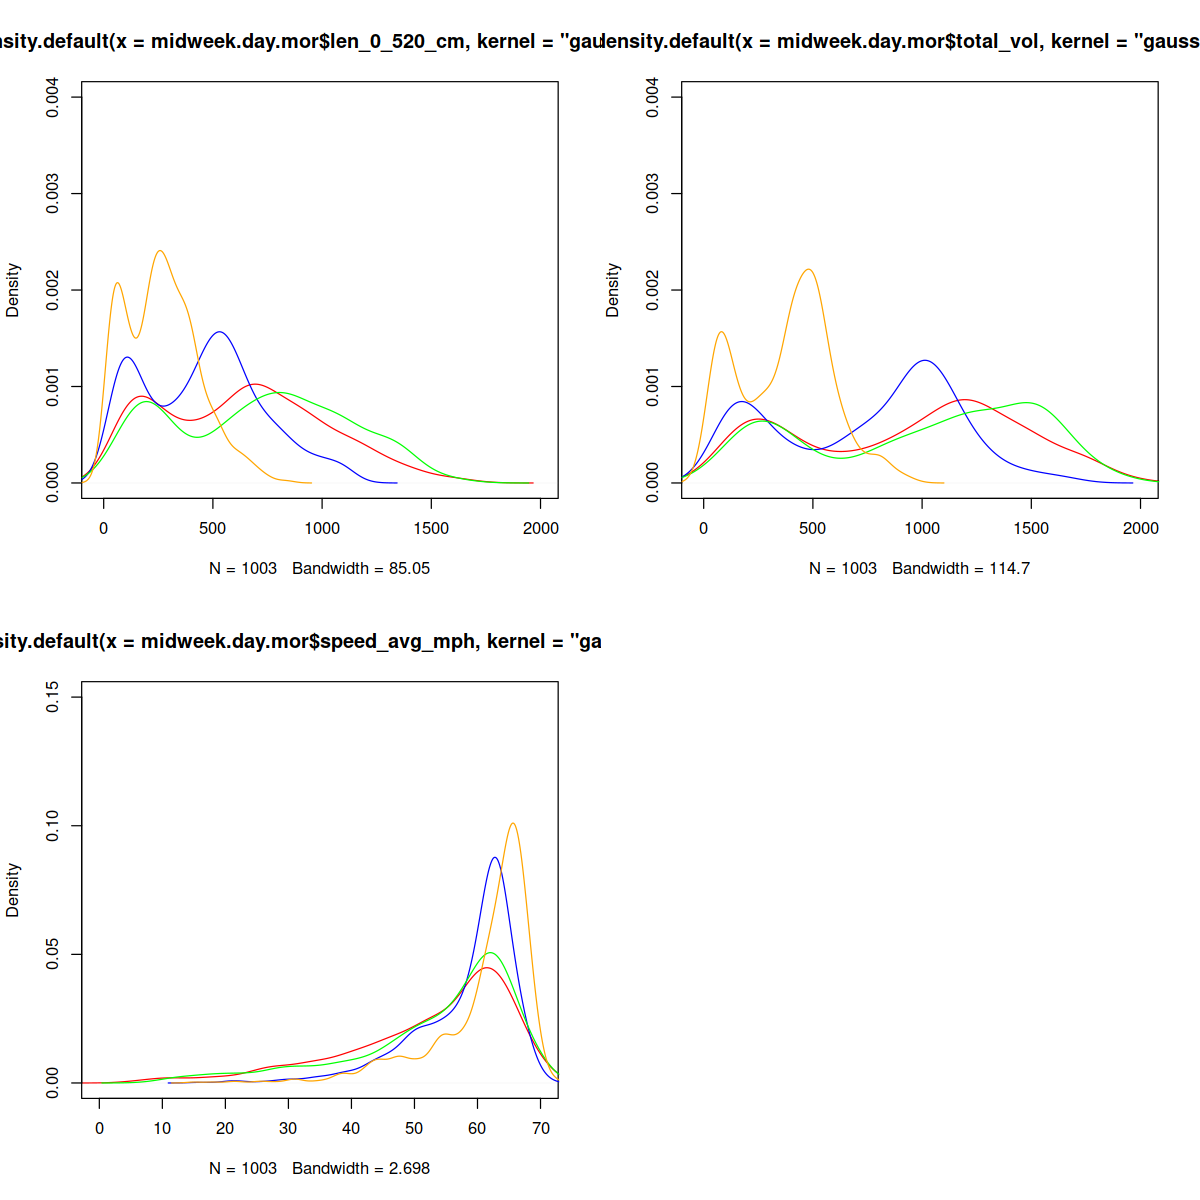

In [22]:
# multi modal
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(2, 2))

plot( density(midweek.day.mor$len_0_520_cm, kernel = "gaussian"), col="red", xlim=c(-20, 2000), ylim=c(0, 0.004))
lines(density(midweek.day.mid$len_0_520_cm, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$len_0_520_cm, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$len_0_520_cm, kernel = "gaussian"), col="orange")

plot( density(midweek.day.mor$total_vol, kernel = "gaussian"), col="red", xlim=c(-20, 2000), ylim=c(0, 0.004))
lines(density(midweek.day.mid$total_vol, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$total_vol, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$total_vol, kernel = "gaussian"), col="orange")

plot( density(midweek.day.mor$speed_avg_mph, kernel = "gaussian"), col="red", xlim=c(0, 70), ylim=c(0, 0.15))
lines(density(midweek.day.mid$speed_avg_mph, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$speed_avg_mph, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$speed_avg_mph, kernel = "gaussian"), col="orange")

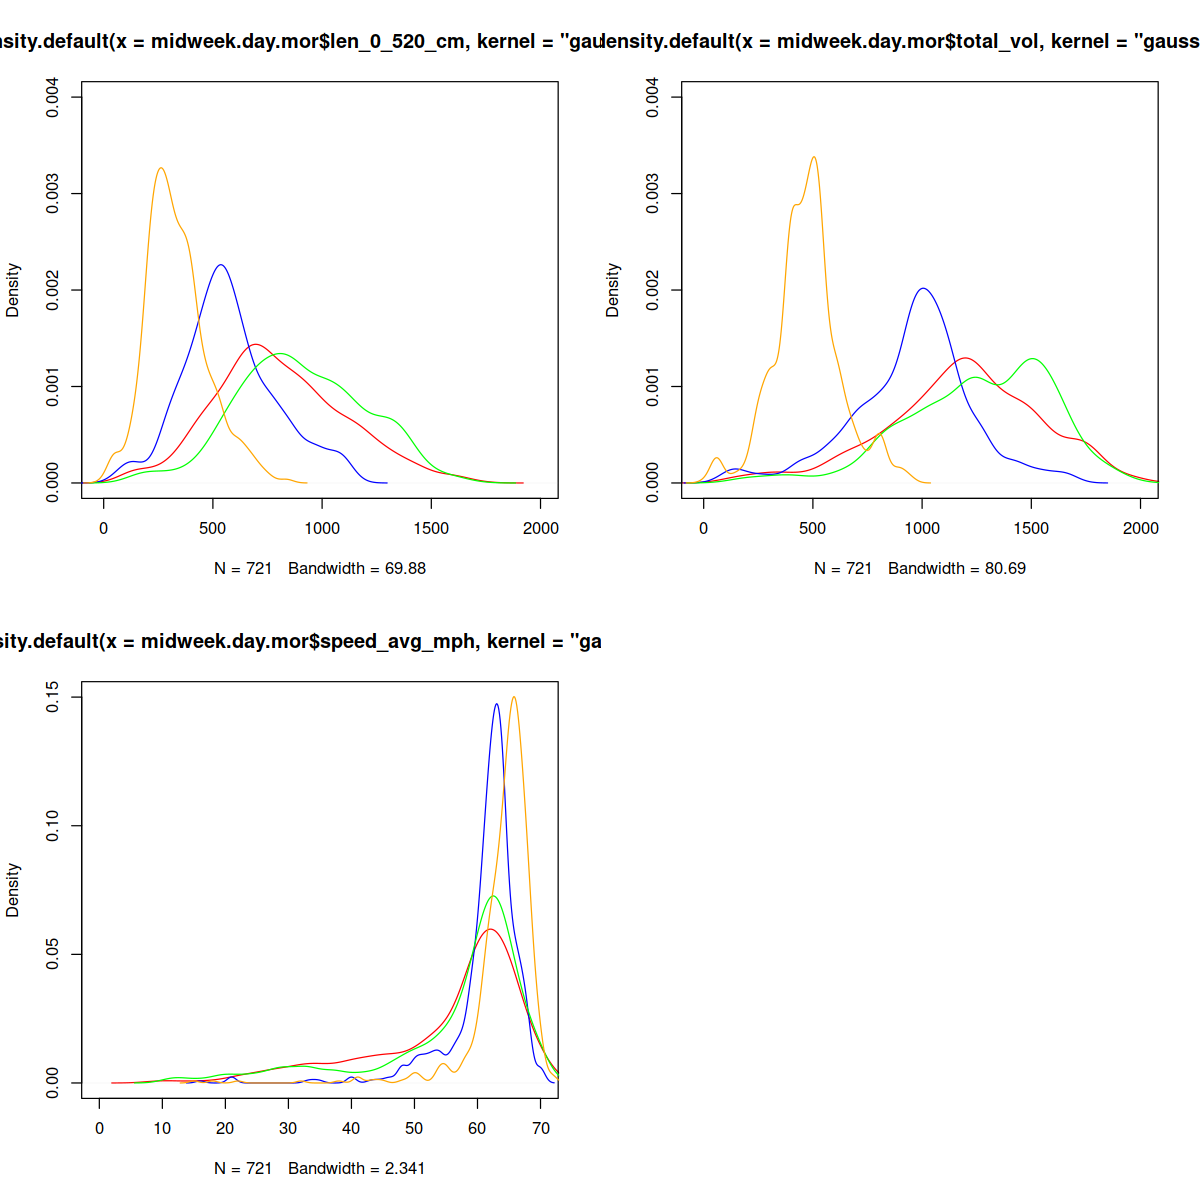

In [23]:
# no sliproads (A = clockwise, B = anti-clockwise)
# now single mode.
sensors <- "[AB]$"
midweek.day.3am <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "02:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.mor <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "08:29:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.mid <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "11:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.aft <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "16:59:00" & grepl(sensors, tmp$site_name) , ]
midweek.day.eve <- tmp[tmp$report_date=="2018-10-03" & tmp$time_period_end == "20:59:00" & grepl(sensors, tmp$site_name) , ]

options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(2, 2))

plot( density(midweek.day.mor$len_0_520_cm, kernel = "gaussian"), col="red", xlim=c(-20, 2000), ylim=c(0, 0.004))
lines(density(midweek.day.mid$len_0_520_cm, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$len_0_520_cm, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$len_0_520_cm, kernel = "gaussian"), col="orange")

plot( density(midweek.day.mor$total_vol, kernel = "gaussian"), col="red", xlim=c(-20, 2000), ylim=c(0, 0.004))
lines(density(midweek.day.mid$total_vol, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$total_vol, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$total_vol, kernel = "gaussian"), col="orange")

plot( density(midweek.day.mor$speed_avg_mph, kernel = "gaussian"), col="red", xlim=c(0, 70), ylim=c(0, 0.15))
lines(density(midweek.day.mid$speed_avg_mph, kernel = "gaussian"), col="blue")
lines(density(midweek.day.aft$speed_avg_mph, kernel = "gaussian"), col="green")
lines(density(midweek.day.eve$speed_avg_mph, kernel = "gaussian"), col="orange")

In [24]:
count_mean <- NULL
count_median <- NULL
count_sd <- NULL
count_skewness <- NULL
count_kurtosis <- NULL


speed_mean <- NULL
speed_median <- NULL
speed_sd <- NULL
speed_skewness <- NULL
speed_kurtosis <- NULL

csvs <- paste0("/mnt/nvme/phil/", c(rep(2016, 12), rep(2017, 12), rep(2018, 12)), "-", sprintf("%02d.csv", 1:12))
#csvs <- paste0("/mnt/nvme/phil/", c(rep(2018, 1)), "-", sprintf("%02d.csv", 9:12))
csvs <- head(csvs, -2)
csvs
if(T){
for(csv in csvs) {
    message(paste("processing", csv, "..."))
    x <- process_month(csv)
    count_mean <- rbind(count_mean, x$count_mean)
    count_median <- rbind(count_median, x$count_median)
    count_sd <- rbind(count_sd, x$count_sd)
    count_skewness <- rbind(count_skewness, x$count_skewness)
    count_kurtosis <- rbind(count_kurtosis, x$count_kurtosis)
    
    speed_mean <- rbind(speed_mean, x$speed_mean)
    speed_median <- rbind(speed_median, x$speed_median)
    speed_sd <- rbind(speed_sd, x$speed_sd)
    speed_skewness <- rbind(speed_skewness, x$speed_skewness)
    speed_kurtosis <- rbind(speed_kurtosis, x$speed_kurtosis)
    
    gc()
}}
message("done.")

[1] "/mnt/nvme/phil/2016-01.csv" "/mnt/nvme/phil/2016-02.csv"
 [3] "/mnt/nvme/phil/2016-03.csv" "/mnt/nvme/phil/2016-04.csv"
 [5] "/mnt/nvme/phil/2016-05.csv" "/mnt/nvme/phil/2016-06.csv"
 [7] "/mnt/nvme/phil/2016-07.csv" "/mnt/nvme/phil/2016-08.csv"
 [9] "/mnt/nvme/phil/2016-09.csv" "/mnt/nvme/phil/2016-10.csv"
[11] "/mnt/nvme/phil/2016-11.csv" "/mnt/nvme/phil/2016-12.csv"
[13] "/mnt/nvme/phil/2017-01.csv" "/mnt/nvme/phil/2017-02.csv"
[15] "/mnt/nvme/phil/2017-03.csv" "/mnt/nvme/phil/2017-04.csv"
[17] "/mnt/nvme/phil/2017-05.csv" "/mnt/nvme/phil/2017-06.csv"
[19] "/mnt/nvme/phil/2017-07.csv" "/mnt/nvme/phil/2017-08.csv"
[21] "/mnt/nvme/phil/2017-09.csv" "/mnt/nvme/phil/2017-10.csv"
[23] "/mnt/nvme/phil/2017-11.csv" "/mnt/nvme/phil/2017-12.csv"
[25] "/mnt/nvme/phil/2018-01.csv" "/mnt/nvme/phil/2018-02.csv"
[27] "/mnt/nvme/phil/2018-03.csv" "/mnt/nvme/phil/2018-04.csv"
[29] "/mnt/nvme/phil/2018-05.csv" "/mnt/nvme/phil/2018-06.csv"
[31] "/mnt/nvme/phil/2018-07.csv" "/mnt/nvme/phil/2018-08.csv"
[33] "/mnt/nvme/phil/2018-09.csv" "/mnt/nvme/phil/2018-10.csv"

processing /mnt/nvme/phil/2016-01.csv ...
before = 1315 after = 887 sensors.
processing /mnt/nvme/phil/2016-02.csv ...
before = 1299 after = 872 sensors.
processing /mnt/nvme/phil/2016-03.csv ...
before = 1285 after = 859 sensors.
processing /mnt/nvme/phil/2016-04.csv ...
before = 1453 after = 986 sensors.
processing /mnt/nvme/phil/2016-05.csv ...
before = 1307 after = 881 sensors.
processing /mnt/nvme/phil/2016-06.csv ...
before = 1314 after = 888 sensors.
processing /mnt/nvme/phil/2016-07.csv ...
before = 1316 after = 888 sensors.
processing /mnt/nvme/phil/2016-08.csv ...
before = 1305 after = 882 sensors.
processing /mnt/nvme/phil/2016-09.csv ...
before = 1291 after = 875 sensors.
processing /mnt/nvme/phil/2016-10.csv ...
before = 1275 after = 858 sensors.
processing /mnt/nvme/phil/2016-11.csv ...
before = 1283 after = 858 sensors.
processing /mnt/nvme/phil/2016-12.csv ...
before = 1273 after = 853 sensors.
processing /mnt/nvme/phil/2017-01.csv ...
before = 1286 after = 866 sensors.

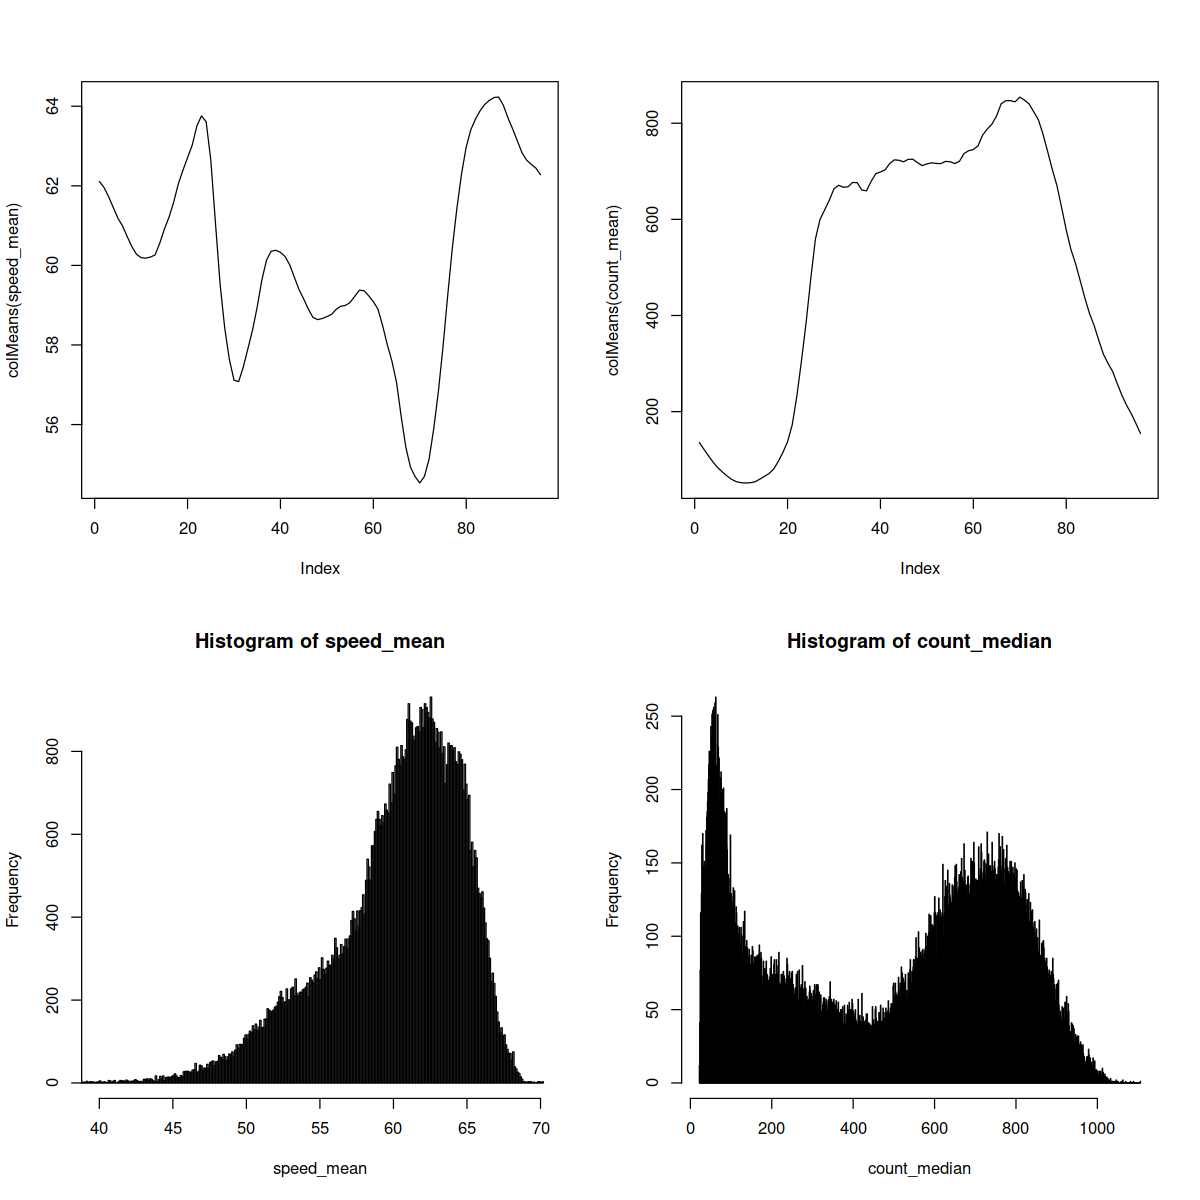

In [25]:
par(mfrow = c(2, 2))
plot(colMeans(speed_mean), type="l")
plot(colMeans(count_mean), type="l")
hist(speed_mean, breaks=1000, xlim=c(40,70))
hist(count_median, breaks=1000)

In [26]:
tail(speed_kurtosis)

,0,1,2,3,4,5,6,7,8,9,⋯,86,87,88,89,90,91,92,93,94,95
2018-10-26,7.11,8.01,9.53,8.09,8.46,9.69,9.89,9.81,9.35,12.33,⋯,26.42,40.90,43.25,53.43,48.80,37.43,32.03,24.65,20.32,21.23
2018-10-27,10.57,10.07,9.74,10.63,9.87,11.38,11.40,11.26,10.58,10.86,⋯,23.95,24.99,17.56,11.14,10.14,11.63,10.44,20.81,21.47,22.48
2018-10-28,36.40,39.09,40.41,47.56,35.00,26.14,23.89,51.50,39.15,34.69,⋯,12.45,12.97,15.41,16.37,16.58,22.84,27.02,36.16,34.55,32.05
2018-10-29,13.30,60.16,12.67,58.02,57.08,57.32,62.55,60.52,58.03,13.72,⋯,45.26,31.89,27.42,30.38,23.71,12.78,12.30,13.90,13.93,13.99
2018-10-30,16.58,13.80,15.18,15.12,15.15,14.89,15.86,17.74,16.69,15.77,⋯,50.72,33.42,18.36,16.65,12.49,9.51,9.89,9.14,11.01,11.22
2018-10-31,13.60,12.69,12.19,11.59,12.15,12.28,13.13,13.93,12.49,16.65,⋯,51.44,42.29,29.60,26.03,24.01,26.77,21.67,20.28,23.81,21.14


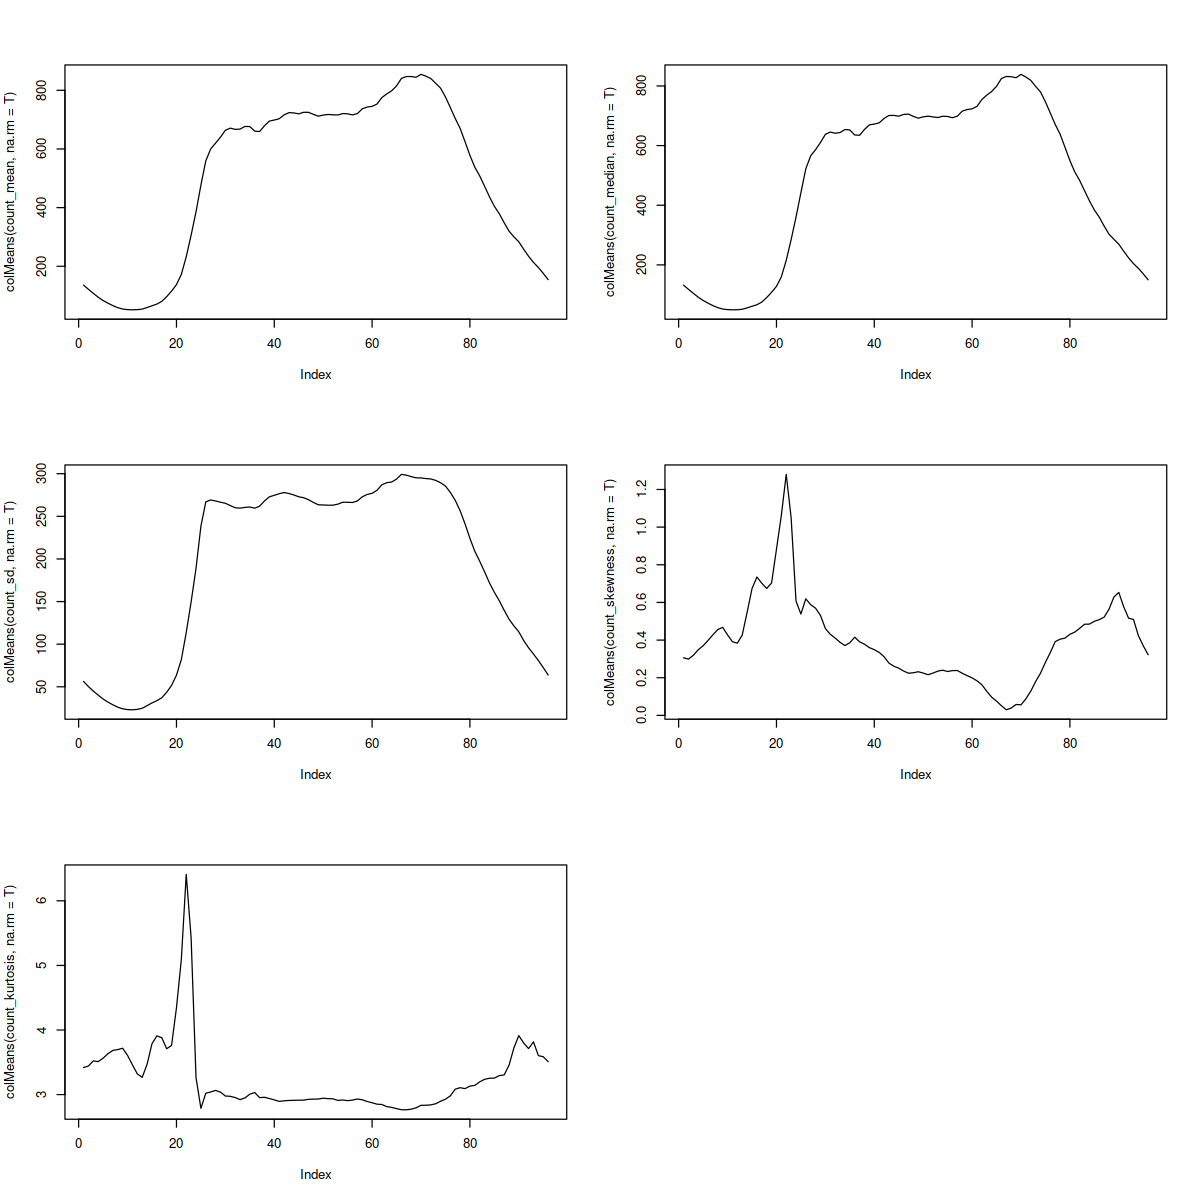

In [27]:
par(mfrow = c(3,2))
plot(colMeans(count_mean, na.rm = T), type="l")
plot(colMeans(count_median, na.rm = T), type="l")
plot(colMeans(count_sd, na.rm = T), type="l")
plot(colMeans(count_skewness, na.rm = T), type="l")
plot(colMeans(count_kurtosis, na.rm = T), type="l")

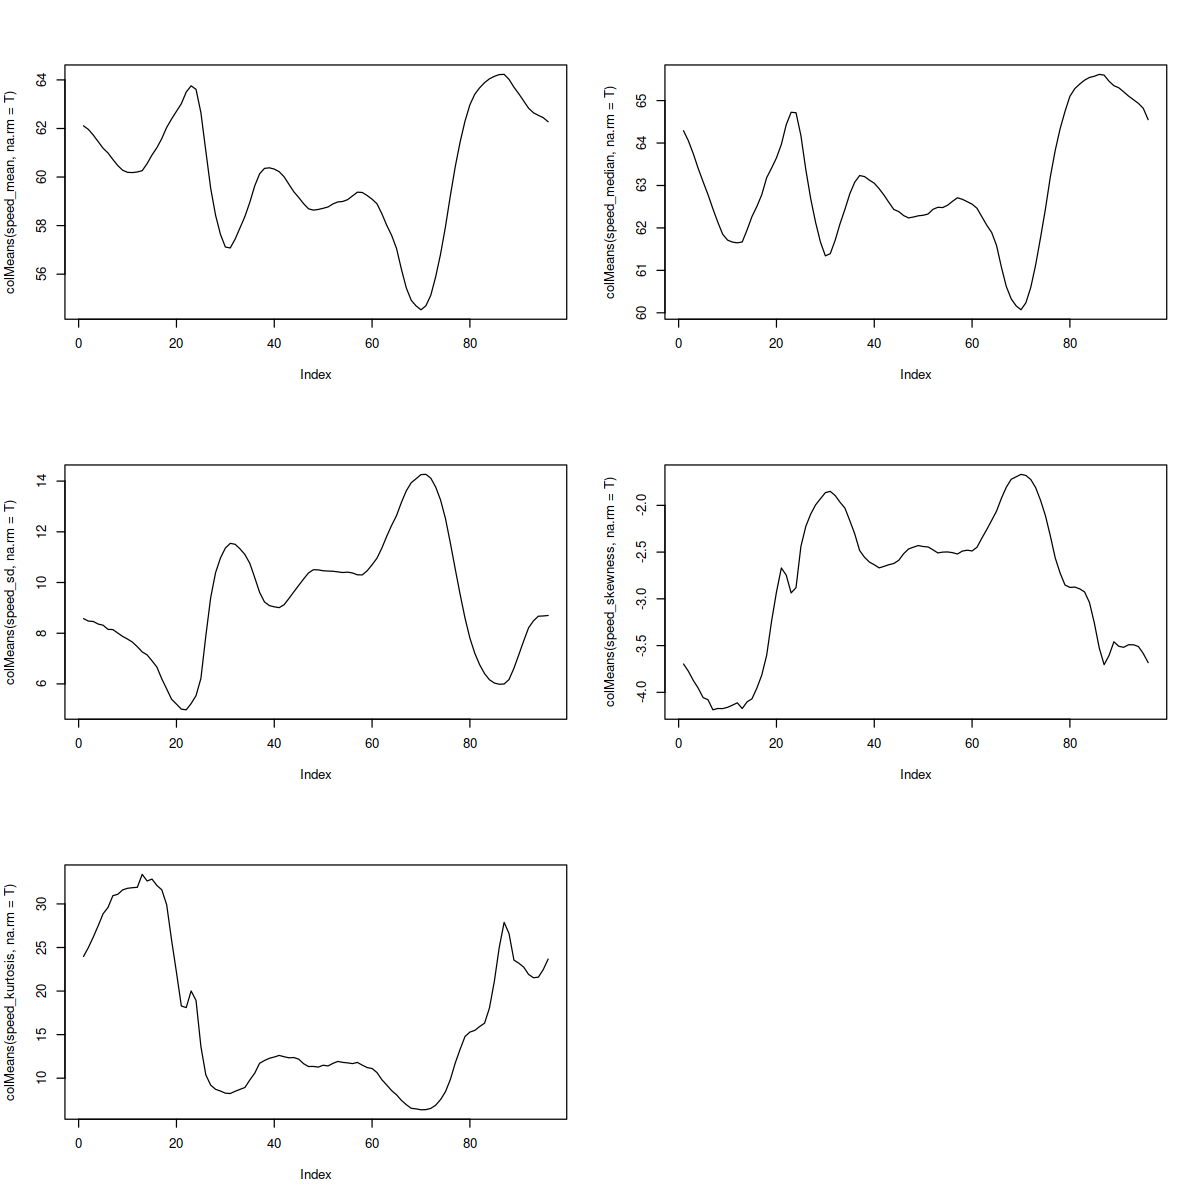

In [28]:
par(mfrow = c(3,2))
plot(colMeans(speed_mean, na.rm = T), type="l")
plot(colMeans(speed_median, na.rm = T), type="l")
plot(colMeans(speed_sd, na.rm = T), type="l")
plot(colMeans(speed_skewness, na.rm = T), type="l")
plot(colMeans(speed_kurtosis, na.rm = T), type="l")

In [29]:
# just for fun
if(F) {
    for(day.key in rownames(count_skewness)) {
        png(paste0("/tmp/", day.key, ".png"))
        plot(count_skewness[rownames(count_skewness) == day.key, ], type="l", main=day.key)
        dev.off()
    }
}

In [30]:
# missing
date.range <- as.character(seq(from=as.Date("2016-01-01"), to=as.Date("2018-10-31"), by=1))
missing <- date.range[!(date.range %in% rownames(count_mean))]
missing

[1] "2016-03-16" "2016-03-27" "2016-04-06" "2016-04-07" "2016-04-08"
  [6] "2016-04-09" "2016-04-10" "2016-04-11" "2016-05-05" "2016-05-06"
 [11] "2016-05-07" "2016-05-08" "2016-05-09" "2016-05-10" "2016-05-11"
 [16] "2016-05-13" "2016-05-14" "2016-05-15" "2016-05-19" "2016-06-01"
 [21] "2016-06-02" "2016-06-08" "2016-06-09" "2016-06-14" "2016-06-16"
 [26] "2016-07-18" "2016-07-20" "2016-07-21" "2016-08-01" "2016-08-10"
 [31] "2016-08-15" "2016-08-16" "2016-08-17" "2016-08-18" "2016-08-19"
 [36] "2016-09-04" "2016-09-05" "2016-09-06" "2016-09-07" "2016-09-08"
 [41] "2016-09-15" "2016-09-16" "2016-10-07" "2016-10-08" "2016-10-10"
 [46] "2016-10-11" "2016-10-17" "2016-10-18" "2016-10-19" "2016-10-31"
 [51] "2016-11-21" "2016-11-29" "2016-12-06" "2016-12-14" "2016-12-15"
 [56] "2016-12-16" "2016-12-17" "2016-12-18" "2016-12-19" "2016-12-20"
 [61] "2017-01-03" "2017-01-04" "2017-01-05" "2017-01-21" "2017-02-14"
 [66] "2017-03-08" "2017-03-11" "2017-03-26" "2017-03-30" "2017-03-31"
 [71] "2017-04-07" "2017-04-11" "2017-05-04" "2017-05-12" "2017-05-13"
 [76] "2017-05-14" "2017-05-15" "2017-05-17" "2017-05-18" "2017-05-19"
 [81] "2017-05-20" "2017-05-21" "2017-05-22" "2017-05-23" "2017-05-26"
 [86] "2017-05-27" "2017-07-02" "2017-07-06" "2017-07-07" "2017-07-08"
 [91] "2017-07-09" "2017-07-10" "2017-07-13" "2017-07-14" "2017-07-15"
 [96] "2017-07-16" "2017-07-17" "2017-07-18" "2017-07-19" "2017-07-21"
[101] "2017-07-22" "2017-07-23" "2017-07-24" "2017-07-28" "2017-07-29"
[106] "2017-07-30" "2017-07-31" "2017-08-07" "2017-08-08" "2017-08-15"
[111] "2017-08-16" "2017-08-24" "2017-10-17" "2017-11-16" "2017-11-23"
[116] "2017-11-24" "2017-11-25" "2018-01-12" "2018-02-23" "2018-03-25"
[121] "2018-04-09" "2018-04-10" "2018-05-09" "2018-06-24" "2018-06-25"
[126] "2018-08-12" "2018-08-13" "2018-08-14" "2018-08-30" "2018-09-05"
[131] "2018-10-02" "2018-10-03" "2018-10-07" "2018-10-08" "2018-10-14"
[136] "2018-10-15" "2018-10-16" "2018-10-17"

In [31]:
write.csv(missing, "../data/highways_england/all_london/missing.csv", row.names=F)

In [32]:
flatten <- function(df) as.vector(matrix(t(df), ncol=1))
melt <- data.frame(tod=1:96, count=flatten(count_skewness))
head(melt)

tod,count
1,0.27
2,1.15
3,1.33
4,0.94
5,1.22
6,1.62


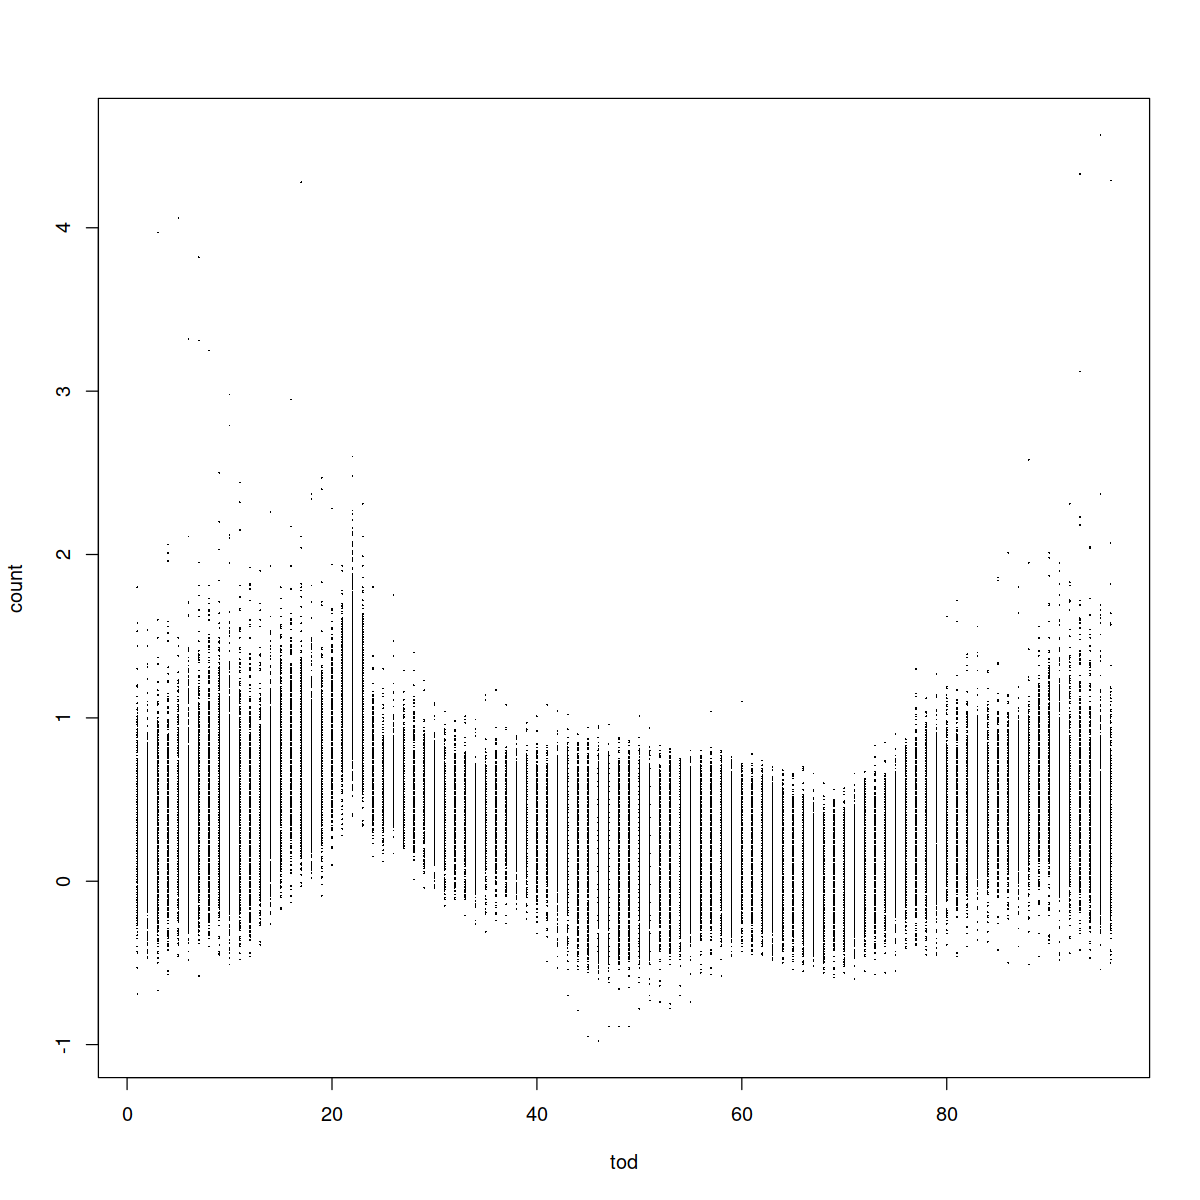

In [33]:
plot(melt, cex=0.2, pch=16)

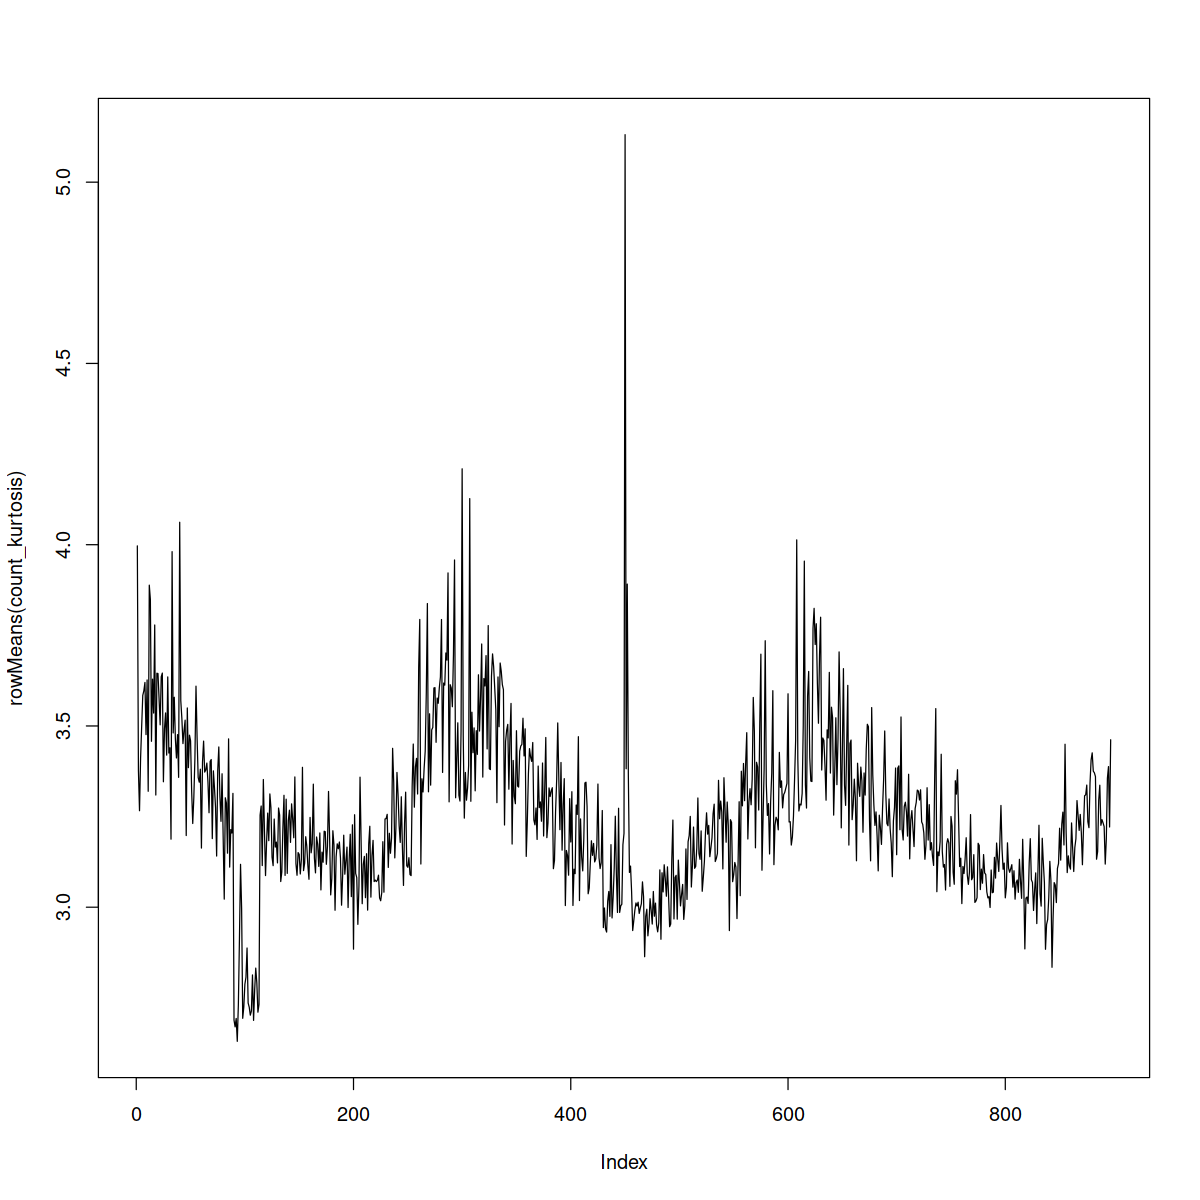

In [34]:
plot(rowMeans(count_kurtosis), type="l")

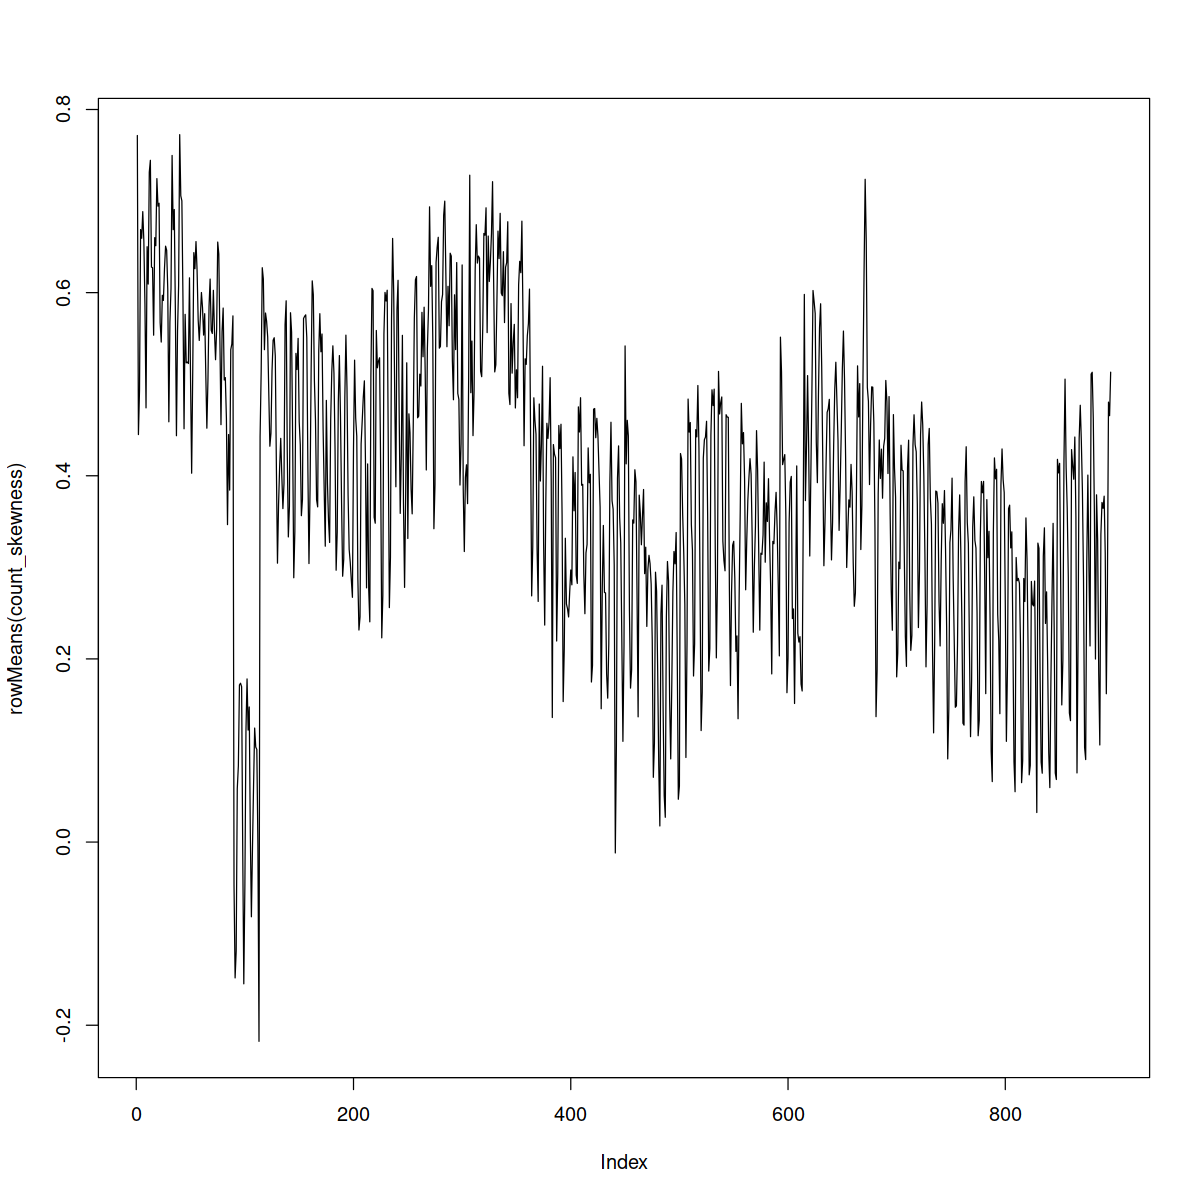

In [35]:
plot(rowMeans(count_skewness), type="l")

In [36]:
flatten <- function(df) as.vector(matrix(t(df), ncol=1))

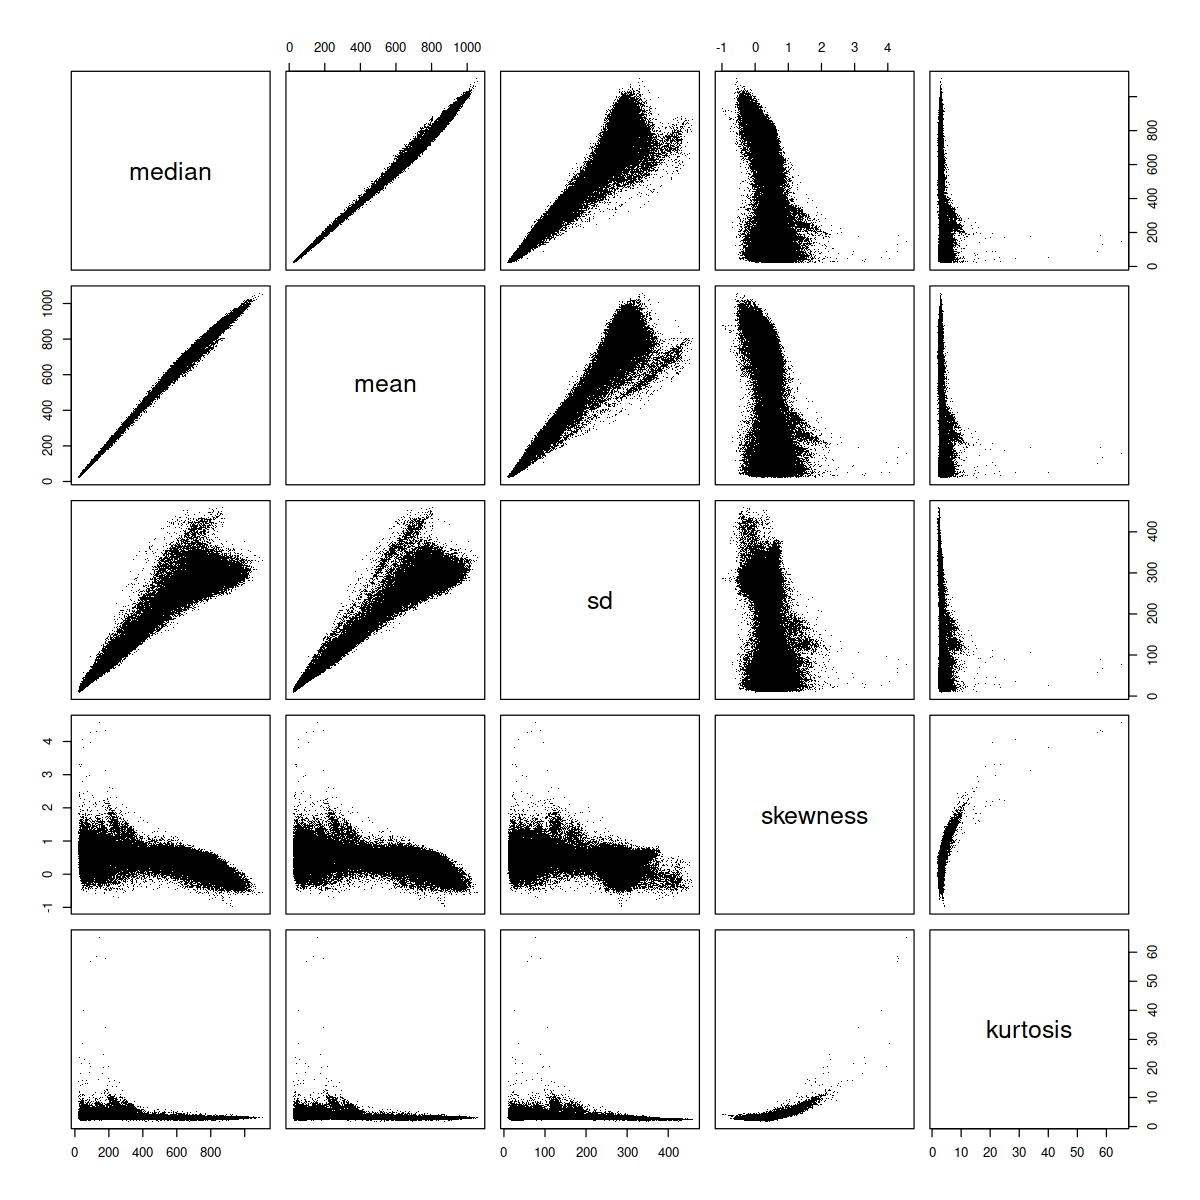

In [37]:
plot(data.frame(median=flatten((count_median)), mean=flatten(count_mean), sd=flatten(count_sd), skewness=flatten(count_skewness), kurtosis=flatten(count_kurtosis)), pch=".")

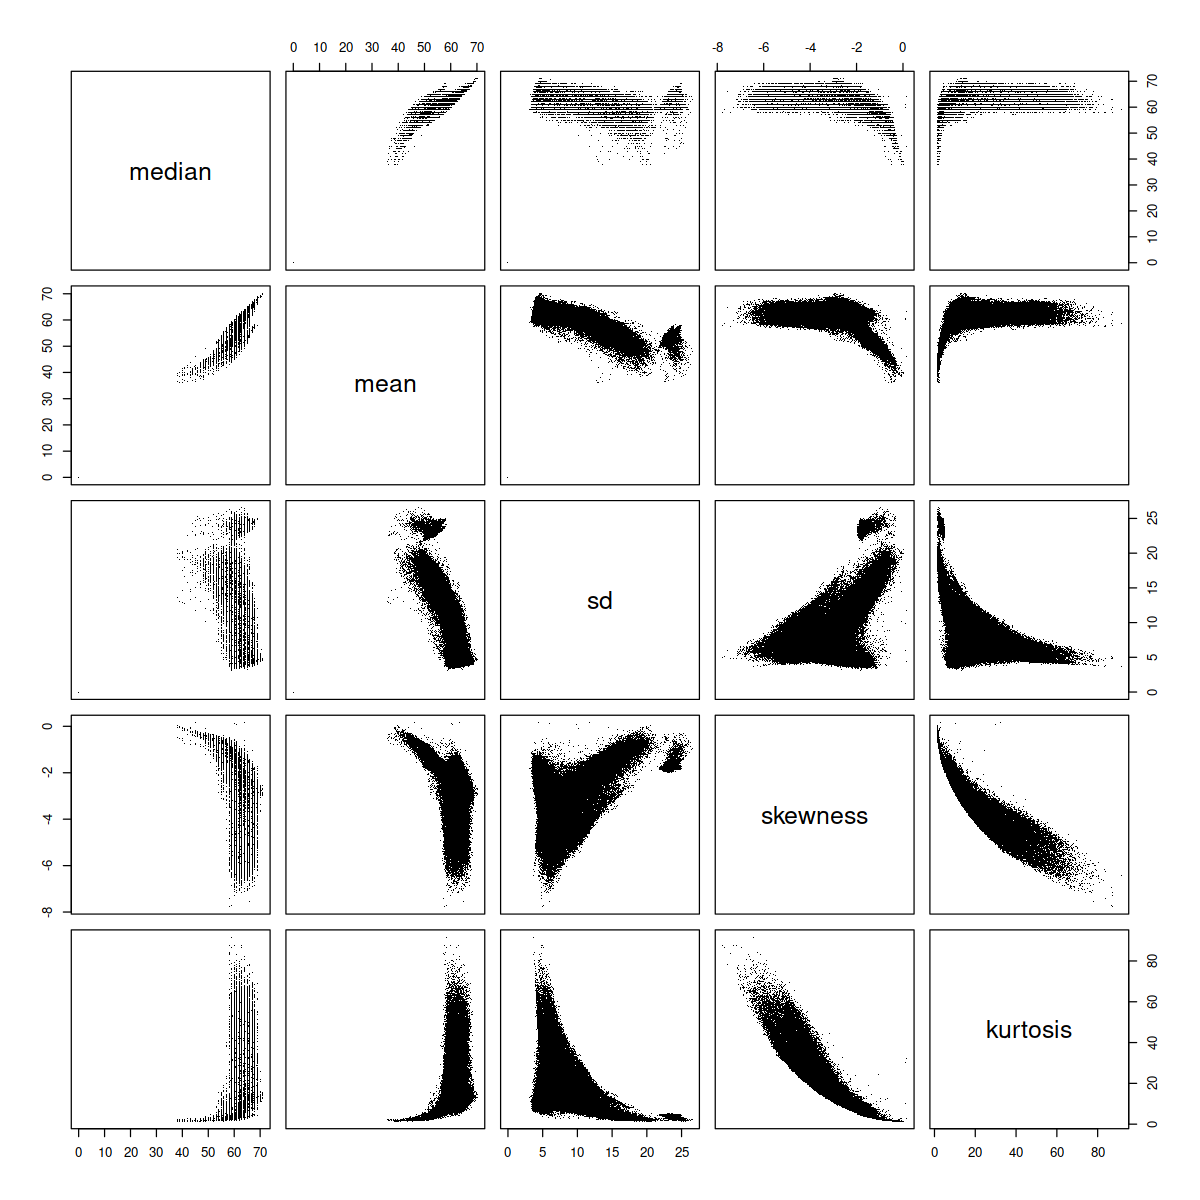

In [38]:
plot(data.frame(median=flatten((speed_median)), mean=flatten(speed_mean), sd=flatten(speed_sd), skewness=flatten(speed_skewness), kurtosis=flatten(speed_kurtosis)), pch=".")

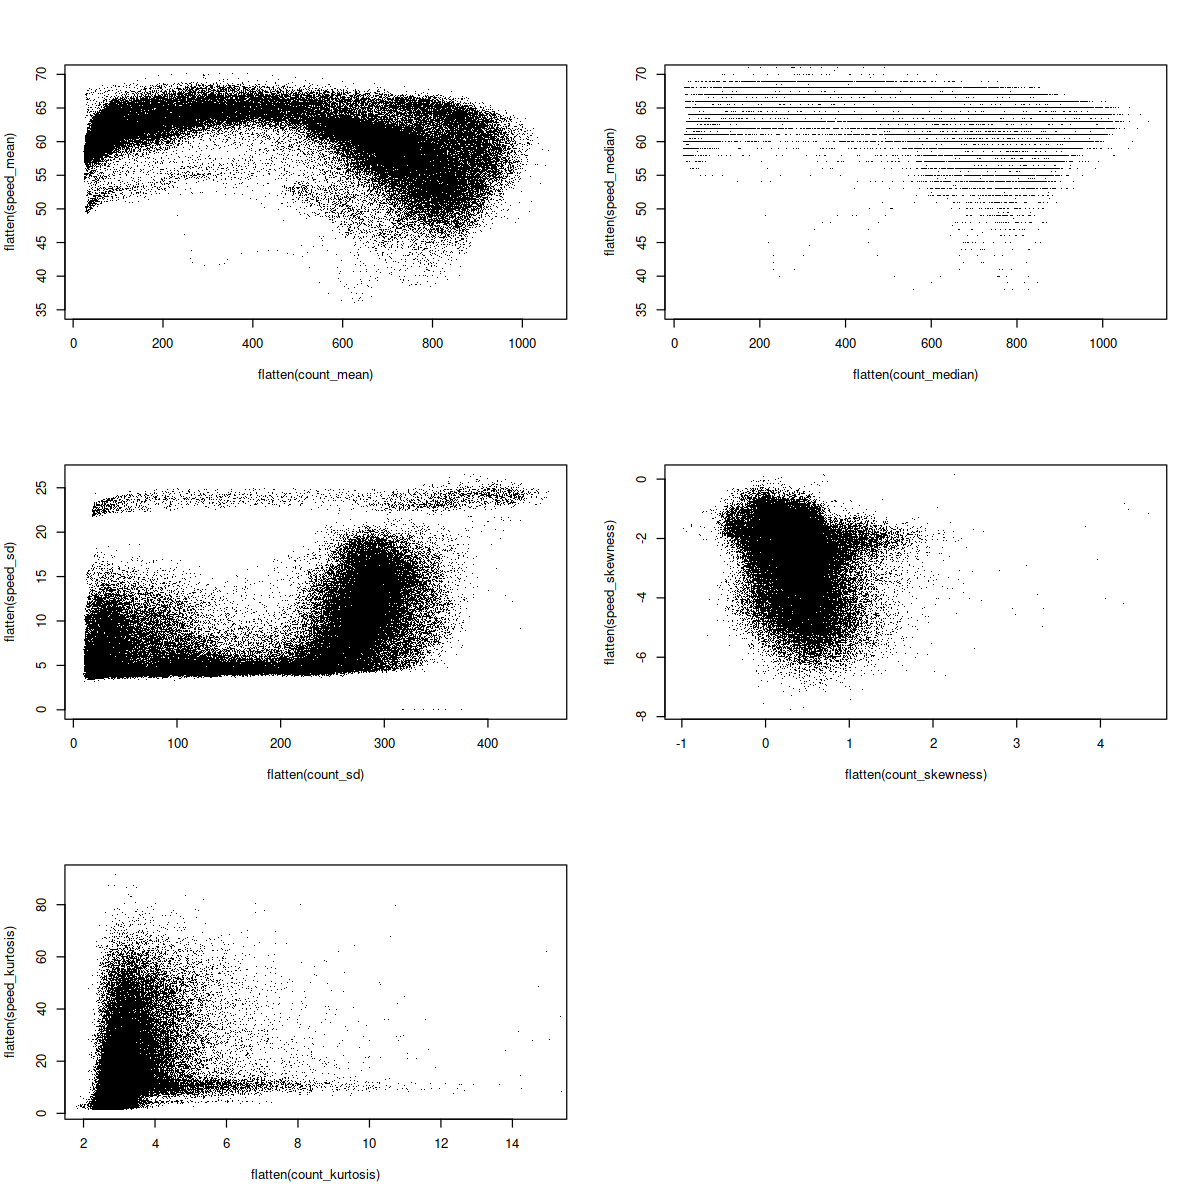

In [39]:
par(mfrow = c(3,2))
# speed increases with count until ~400, then flips. ~400 = max throughput
plot(flatten(count_mean), flatten(speed_mean), pch=".", ylim=c(35,70))
plot(flatten(count_median), flatten(speed_median), pch=".", ylim=c(35,70))
plot(flatten(count_sd), flatten(speed_sd), pch=".")
plot(flatten(count_skewness), flatten(speed_skewness), pch=".")
plot(flatten(count_kurtosis), flatten(speed_kurtosis), pch=".", xlim=c(2, 15))

In [40]:
means <- rowMeans(count_mean)
data.frame(tapply(means, weekdays(as.Date(names(means))), mean))

,tapply.means..weekdays.as.Date.names.means.....mean.
Friday,519.6181
Monday,487.6350
Saturday,515.3115
Sunday,518.4546
Thursday,500.7139
Tuesday,485.4452
Wednesday,491.7056


In [41]:
if(F){
write.csv(count_mean, "../data/highways_england/all_london/count_mean_2016-2018.csv")
write.csv(count_median, "../data/highways_england/all_london/count_median_2016-2018.csv")
write.csv(count_sd, "../data/highways_england/all_london/count_sd_2016-2018.csv")
write.csv(count_skewness, "../data/highways_england/all_london/count_skewness_2016-2018.csv")
write.csv(count_kurtosis, "../data/highways_england/all_london/count_kurtosis_2016-2018.csv")
write.csv(speed_mean, "../data/highways_england/all_london/speed_mean_2016-2018.csv")
write.csv(speed_median, "../data/highways_england/all_london/speed_median_2016-2018.csv")
write.csv(speed_sd, "../data/highways_england/all_london/speed_sd_2016-2018.csv")
write.csv(speed_skewness, "../data/highways_england/all_london/speed_skewness_2016-2018.csv")
write.csv(speed_kurtosis, "../data/highways_england/all_london/speed_kurtosis_2016-2018.csv")
}